In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn as skl

import time

from mylib import class_distributions
from mylib import data_selection
from mylib import helper_funcs

from mylib.my_xgb import BinaryDecisionTree as BDT
from mylib.my_xgb import add_class

import dtreeviz
import logging
# to suppress messages when plotting trees
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# remove SEKER
new_class_idx = 0
proportion_of_old_data = [0.1*i for i in range(1,10)]
num_models = 5
num_round = 10
num_round_update = [1,5,10]

In [3]:
# set the random seed for numpy
np.random.seed(42)

# define some paths
data_folder = Path("../../../data/DryBeanDataset/")
model_folder = Path("../../../models/DryBeanDataset")
image_folder = Path("../../../images/DryBeanDataset")
file_to_open = data_folder / "Dry_Bean_Dataset.xlsx"


# read and prepare data
data = pd.read_excel(file_to_open)

labels_dict = {key:value for (value,key) in enumerate(data["Class"].unique())}
class_names = np.array(list(labels_dict.keys()))
data["Class"] = data["Class"].map(labels_dict)

# need feature matrix X and labels labels for xgboost
labels = data["Class"]
X = data.drop(["Class"],axis=1,inplace=False)

In [4]:
# prepare smaller dataset with only first num_labels classes of beans
old_classes = np.delete(np.sort(labels.unique()), new_class_idx)
new_class = new_class_idx

# compute number of old labels used
num_labels = len(old_classes)

# relabel for XGBoost
labels, relabel_dict = helper_funcs.relabel(labels, old_classes, new_class)

# relabel class_names
relabel_dict_sorted=dict(sorted(relabel_dict.items(), key=lambda item: item[1]))
class_names = class_names[list(relabel_dict_sorted.keys())]

# the "original" training data
data_small = X[labels < num_labels]
labels_small = labels[labels < num_labels]

data_small.reset_index(drop=True, inplace=True)
labels_small.reset_index(drop=True, inplace=True)

# to check full model on all of the old data
dsmall = xgb.DMatrix(data_small, label=labels_small)

# attempt to retrain with new data
new_class_data = X[labels == num_labels]
new_class_labels = labels[labels == num_labels]

# only to check performance on the newly added data
dnew_class = xgb.DMatrix(new_class_data, label=new_class_labels)

# also train a model with all the data availale for comparison
data_full = pd.concat([data_small, new_class_data])
labels_full = pd.concat([labels_small, new_class_labels])

dfull = xgb.DMatrix(data_full, label=labels_full)

In [5]:
num_round_full = 2*num_round   # here this is the fair comparison model

if num_round_update is None:
    num_round_update=[num_rounds]
max_depth = 3
eta = .1

# parameters for small model
param_small = {'max_depth': max_depth,
               'eta': eta,
               'objective': 'multi:softprob',
               "num_class": num_labels}
param_small['nthread'] = 4
param_small['eval_metric'] = 'mlogloss'

# parameters for update model (the same as for full model, but just in case I want to ever change them)
param_update = {'max_depth': max_depth,
                'eta': eta,
                'objective': 'multi:softprob',
                "num_class": num_labels+1}
param_update['nthread'] = 4
param_update['eval_metric'] = 'mlogloss'

# parameters for full model
param_full = {'max_depth': max_depth,
              'eta': eta,
              'objective': 'multi:softprob',
              "num_class": num_labels+1}
param_full['nthread'] = 4
param_full['eval_metric'] = 'mlogloss'

In [6]:
# split data into train- and test-data
seed = np.random.randint(0,100)
X_train_small, X_test_small, y_train_small, y_test_small = skl.model_selection.train_test_split(data_small,
                                                                                            labels_small,
                                                                                            test_size=.2,
                                                                                            random_state=seed)

dtrain_small = xgb.DMatrix(X_train_small, label=y_train_small)
dtest_small = xgb.DMatrix(X_test_small, label=y_test_small)

evallist_small = [(dtrain_small, 'train'), (dtest_small, 'eval')]


# training a model with all the training data
bst_small = xgb.train(param_small,
                     dtrain_small,
                     num_round,
                     evals=evallist_small,
                     verbose_eval=False)

In [7]:
skl.metrics.accuracy_score(np.argmax(bst_small.predict(dtest_small), axis=1),
                                                     y_test_small)

0.9179974104445403

# PCA for visualization

In [8]:
# normalize
data_normal_full = (X-X.min())/(X.max()-X.min())

# PCA
pca_full = skl.decomposition.PCA(n_components=2)
pca_features_full = pca_full.fit_transform(data_normal_full)
pca_features_full_class_removed = pca_features_full[labels<num_labels]

In [9]:
# normalize
data_normal = (data_small-data_small.min())/(data_small.max()-data_small.min())

# PCA
pca = skl.decomposition.PCA(n_components=2)
pca_features = pca.fit_transform(data_normal)

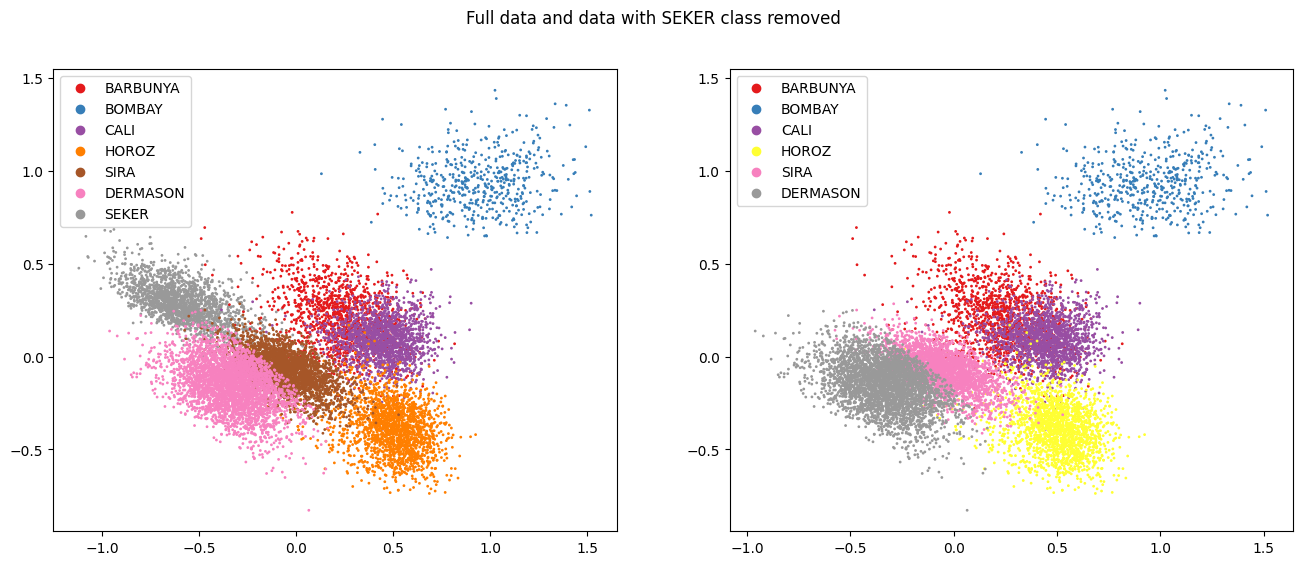

In [10]:
# visualize entropy distribution on data points

legend_labels_full = list(class_names)
legend_labels = list(class_names[:6])
NUM_COLORS = 7
#colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

cm = plt.get_cmap('gist_rainbow')
fig, axs = plt.subplots(1,2,figsize=(16,6))

# plot of data with all classes
axs[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
scatter = axs[0].scatter(pca_features_full[:,0], pca_features_full[:,1], s=1, c=labels, cmap='Set1');
axs[0].legend(handles = scatter.legend_elements()[0], labels=legend_labels_full);

# plot of data with selected data marked
axs[1].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)][:-1])
scatter = axs[1].scatter(pca_features_full_class_removed[:,0], pca_features_full_class_removed[:,1], s=1, c=labels_small, cmap='Set1');
axs[1].legend(handles = scatter.legend_elements()[0], labels=legend_labels);

plt.suptitle(f"Full data and data with {class_names[-1]} class removed");
plt.savefig(image_folder / 'dry_beans_dataset_class_removed.jpg', dpi=300, bbox_inches='tight')

## Split-Criterion

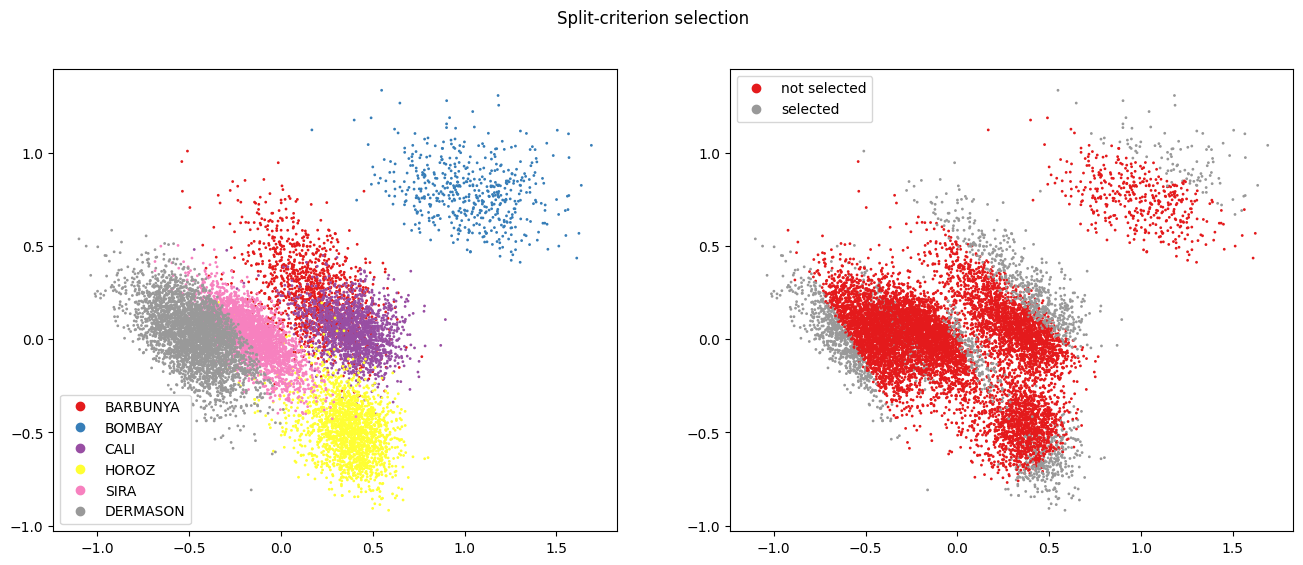

In [11]:
bst_small_df = bst_small.trees_to_dataframe()

# compute important features in model
important_features = data_selection.important_features_by_class(bst_small_df, num_labels, criterion="gain")

# data selection
selected_data = pd.DataFrame(dtype='float64')
selected_data_labels = pd.Series(dtype='int8')

for (label, feature, split_val) in important_features:
    tmp, tmp_labels = data_selection.get_samples_split_value(data_small,
                                                          labels_small,
                                                          feature,
                                                          split_val,
                                                          label,
                                                          ratio_return_total=0.2,
                                                          sort_type="furthest")
    
    selected_data = pd.concat([selected_data, tmp])
    selected_data_labels = pd.concat([selected_data_labels, tmp_labels])

selected_data_binary = np.zeros(len(data_small))
selected_data_binary[selected_data.index] += 1

# visualize entropy distribution on data points

legend_labels = list(class_names[:6])
selection_legend_labels = ['not selected', 'selected']
NUM_COLORS = 6

cm = plt.get_cmap('gist_rainbow')
fig, axs = plt.subplots(1,2,figsize=(16,6))

# plot of data with classes marked
axs[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
scatter = axs[0].scatter(pca_features[:,0], pca_features[:,1], s=1, c=labels_small, cmap='Set1');
axs[0].legend(handles = scatter.legend_elements()[0], labels=legend_labels);

# plot of data with selected data marked
scatter = axs[1].scatter(pca_features[:,0], pca_features[:,1], s=1, c=selected_data_binary, cmap='Set1');
axs[1].legend(handles = scatter.legend_elements()[0], labels=selection_legend_labels);

plt.suptitle("Split-criterion selection");

#plt.savefig(image_folder / 'split_criterion_selection_visualization.jpg', dpi=300, bbox_inches='tight')

## Dist-to-mean

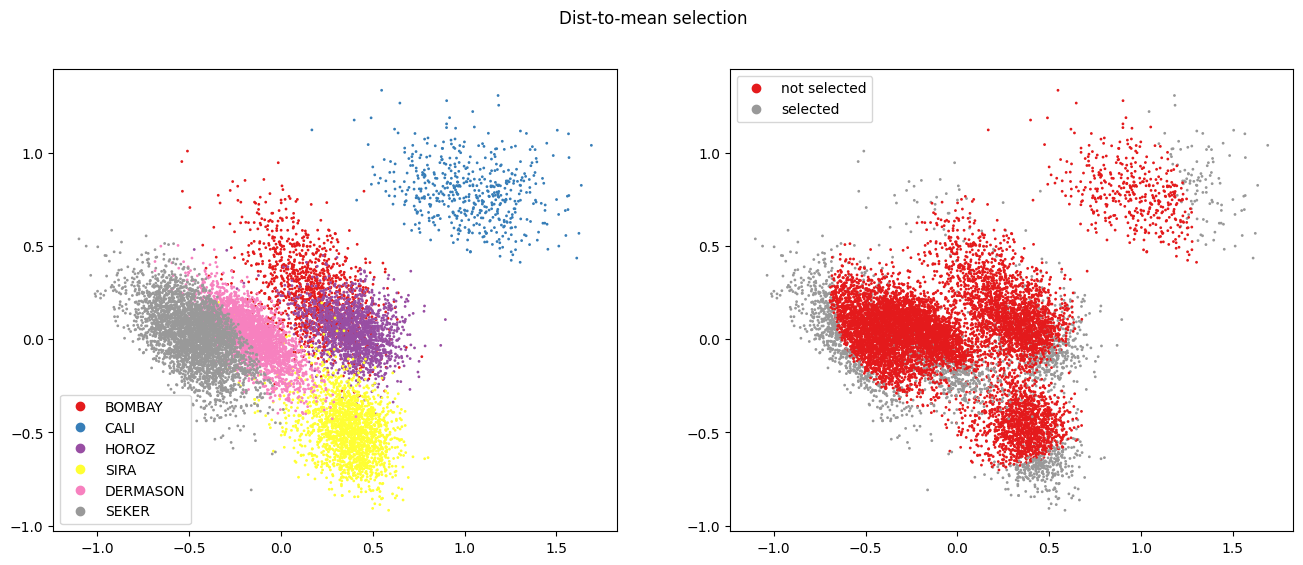

In [12]:
# get critical data
selected_data, selected_data_labels = data_selection.get_samples_euclidean(data_small,
                                                                              labels_small,
                                                                              new_class_data,
                                                                              ratio_return_total = 0.2,
                                                                              normalization="min_max",
                                                                              sort_type="furthest")

selected_data_binary = np.zeros(len(data_small))
selected_data_binary[selected_data.index] += 1

# visualize entropy distribution on data points

legend_labels = list(class_names[old_classes])
selection_legend_labels = ['not selected', 'selected']
NUM_COLORS = 6

cm = plt.get_cmap('gist_rainbow')
fig, axs = plt.subplots(1,2,figsize=(16,6))

# plot of data with classes marked
axs[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
scatter = axs[0].scatter(pca_features[:,0], pca_features[:,1], s=1, c=labels_small, cmap='Set1');
axs[0].legend(handles = scatter.legend_elements()[0], labels=legend_labels);

# plot of data with selected data marked
scatter = axs[1].scatter(pca_features[:,0], pca_features[:,1], s=1, c=selected_data_binary, cmap='Set1');
axs[1].legend(handles = scatter.legend_elements()[0], labels=selection_legend_labels);

plt.suptitle("Dist-to-mean selection");

#plt.savefig(image_folder / 'dist_to_mean_selection_visualization.jpg', dpi=300, bbox_inches='tight')

## Nearest Neighbors

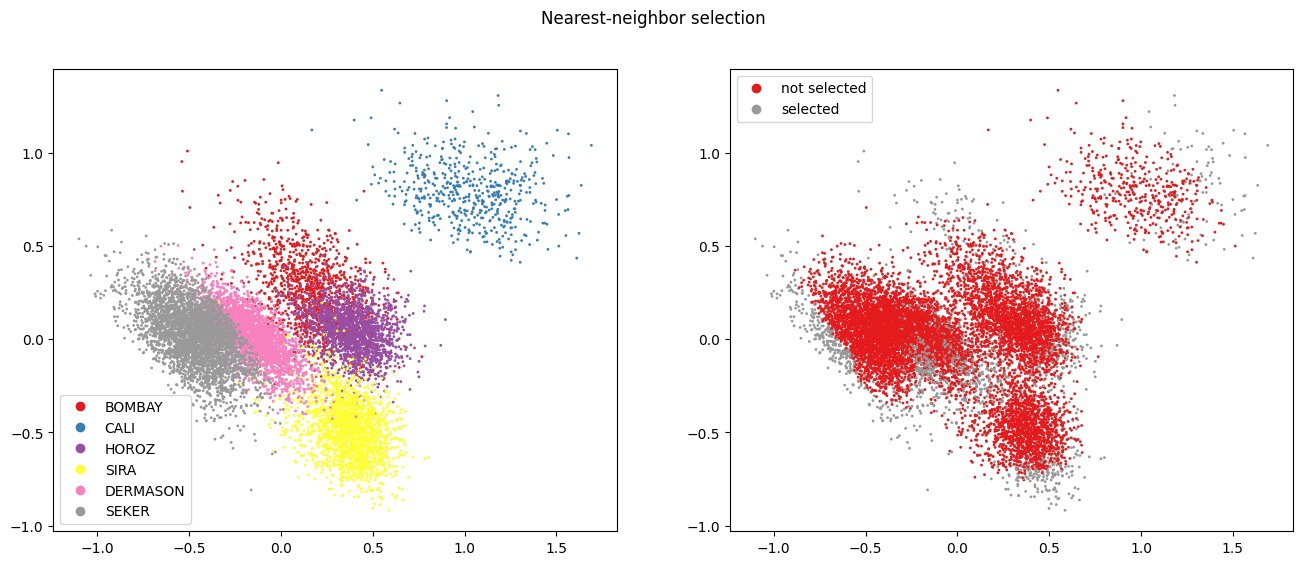

In [16]:
# get critical data
selected_data, selected_data_labels = data_selection.get_samples_nearest_neighbors(data_small,
                                                                                      labels_small,
                                                                                      new_class_data,
                                                                                      ratio_return_total = 0.2,
                                                                                      normalization="min_max",
                                                                                      alpha=0.5,
                                                                                      remove_duplicates=False,
                                                                                      sort_type="furthest")

selected_data_binary = np.zeros(len(data_small))
selected_data_binary[selected_data.index] += 1

# visualize entropy distribution on data points

legend_labels = list(class_names[old_classes])
selection_legend_labels = ['not selected', 'selected']
NUM_COLORS = 6

cm = plt.get_cmap('gist_rainbow')
fig, axs = plt.subplots(1,2,figsize=(16,6))

# plot of data with classes marked
axs[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
scatter = axs[0].scatter(pca_features[:,0], pca_features[:,1], s=1, c=labels_small, cmap='Set1');
axs[0].legend(handles = scatter.legend_elements()[0], labels=legend_labels);

# plot of data with selected data marked
scatter = axs[1].scatter(pca_features[:,0], pca_features[:,1], s=1, c=selected_data_binary, cmap='Set1');
axs[1].legend(handles = scatter.legend_elements()[0], labels=selection_legend_labels);

plt.suptitle("Nearest-neighbor selection");

#plt.savefig(image_folder / 'nearest_neighbors_selection_visualization.jpg', dpi=300, bbox_inches='tight')

## Entropy

/home/dalefi/2023_Fischer_IncrementalLearning/2023_Fischer_Incremental_Tabular_Learning/mylib/mylib/data_selection.py:532: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dalefi/2023_Fischer_IncrementalLearning/2023_Fischer_Incremental_Tabular_Learning/mylib/mylib/data_selection.py:532: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dalefi/2023_Fischer_IncrementalLearning/2023_Fischer_Incremental_Tabular_Learning/mylib/mylib/data_selection.py:532: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dalefi/2023_Fischer_IncrementalLearning/2023_Fischer_Incremental_Tabular_Learning/mylib/mylib/data_selection.py:532: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dalefi/2023_Fischer_IncrementalLearning/2023_Fischer_Incremental_Tabular_Learning/mylib/mylib/data_selection.py:532: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home

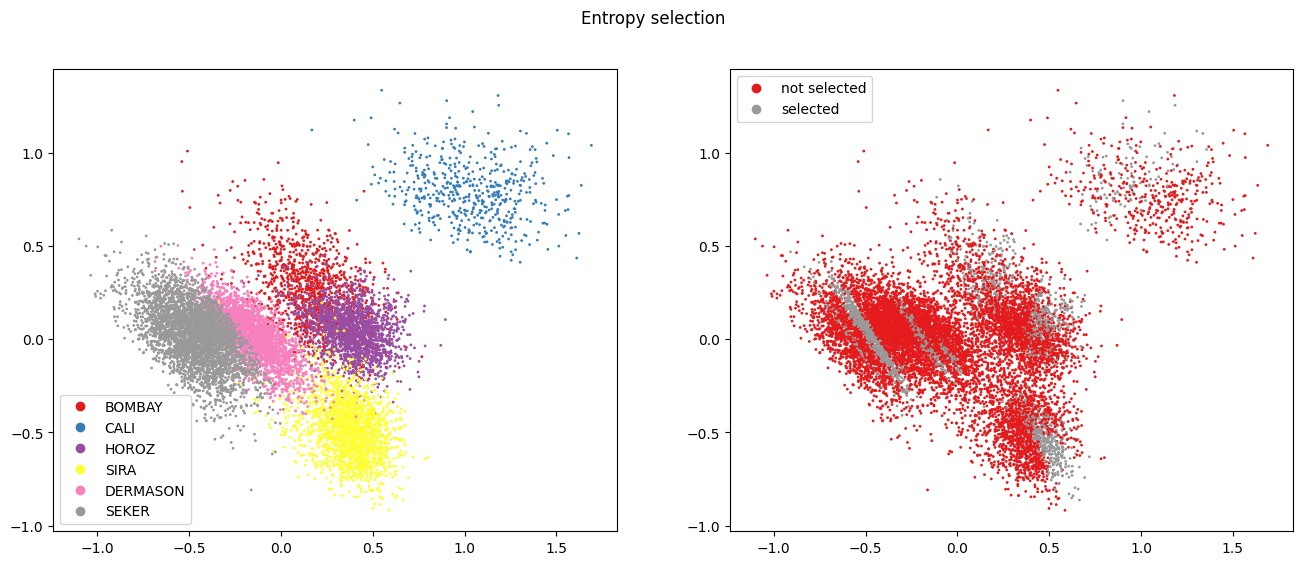

In [14]:
# get critical data
selected_data, selected_data_labels = data_selection.get_samples_entropy(data_small,
                                                                   labels_small,
                                                                   bst_small,
                                                                   ratio_return_total=0.2,
                                                                   sort_type="smallest")

selected_data_binary = np.zeros(len(data_small))
selected_data_binary[selected_data.index] += 1

# visualize entropy distribution on data points

legend_labels = list(class_names[old_classes])
selection_legend_labels = ['not selected', 'selected']
NUM_COLORS = 6

cm = plt.get_cmap('gist_rainbow')
fig, axs = plt.subplots(1,2,figsize=(16,6))

# plot of data with classes marked
axs[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
scatter = axs[0].scatter(pca_features[:,0], pca_features[:,1], s=1, c=labels_small, cmap='Set1');
axs[0].legend(handles = scatter.legend_elements()[0], labels=legend_labels);

# plot of data with selected data marked
scatter = axs[1].scatter(pca_features[:,0], pca_features[:,1], s=1, c=selected_data_binary, cmap='Set1');
axs[1].legend(handles = scatter.legend_elements()[0], labels=selection_legend_labels);

plt.suptitle("Entropy selection");

#plt.savefig(image_folder / 'entropy_selection_visualization.jpg', dpi=300, bbox_inches='tight')

## Random selection

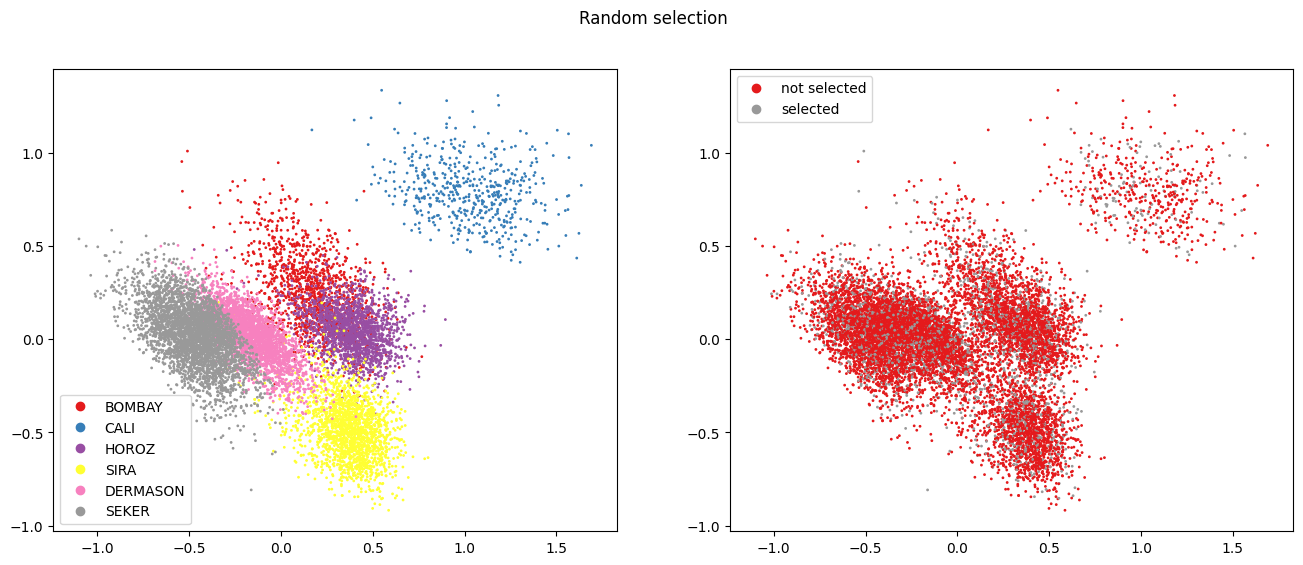

In [15]:
# training model with fewer labels
seed = np.random.randint(0,100)
# split original data into train- and test-data
selected_data, _, selected_data_labels, _ = skl.model_selection.train_test_split(data_small, 
                                                                                labels_small,
                                                                                test_size=.8,
                                                                                random_state=seed,
                                                                                stratify=labels_small)

selected_data_binary = np.zeros(len(data_small))
selected_data_binary[selected_data.index] += 1

# visualize entropy distribution on data points

legend_labels = list(class_names[old_classes])
selection_legend_labels = ['not selected', 'selected']
NUM_COLORS = 6

cm = plt.get_cmap('gist_rainbow')
fig, axs = plt.subplots(1,2,figsize=(16,6))

# plot of data with classes marked
axs[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
scatter = axs[0].scatter(pca_features[:,0], pca_features[:,1], s=1, c=labels_small, cmap='Set1');
axs[0].legend(handles = scatter.legend_elements()[0], labels=legend_labels);

# plot of data with selected data marked
scatter = axs[1].scatter(pca_features[:,0], pca_features[:,1], s=1, c=selected_data_binary, cmap='Set1');
axs[1].legend(handles = scatter.legend_elements()[0], labels=selection_legend_labels);

plt.suptitle("Random selection");

#plt.savefig(image_folder / 'random_selection_visualization.jpg', dpi=300, bbox_inches='tight')